# Lane Keeping

Download bfmc2020 videos from [Drive](https://drive.google.com/file/d/1KJlyvYdHuoplRGTsZ3ghLXyEAir1K32_/view?usp=sharing) and extract it to `./data/`

_Note: Make sure all the images and videos resides in the `./data` directory to prevent pushing the same to Github_


In [1]:
# !conda install -c conda-forge opencv -y

In [20]:
import os
import re
import cv2
from cv2 import VideoCapture
import numpy as np
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
from typing import List, Any, Union, Tuple
import os
import math


## Load Frames from Video


In [3]:
def video2frames(vid_path: str, save_path: str) -> None:
    """Convert videos to frame and save frames.

    Args:
        vid_path: path to video
        save_path: path to save frames to
    """
    assert save_path[-1] == "/", f"Requires a directory, {save_path} must end in '/'"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    vidcap = VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite(save_path + f"{count}.jpg", image)  # save frame as JPEG file
        success, image = vidcap.read()
        count += 1
    print(f"Saved {count} frames to {save_path}.")
    vidcap.release()


# convert bfmc_2020 videos to frames
vid_paths = [
    # "./data/Records/bfmc2020_online_1.avi",
    "./data/Records/bfmc2020_online_2.avi",
    # "./data/Records/bfmc2020_online_1.avi",
]

paths = []
for i, v_path in enumerate(vid_paths):
    path = f"./data/bfmc2020/frames_2/" # edit this 
    paths.append(path)
    video2frames(v_path, path)


Saved 2002 frames to ./data/bfmc2020/frames_2/.


In [4]:
def import_images(path: str) -> List[np.ndarray]:
    """Import all the images of a given directory path and return an array of images

    Args:
        path:(str) path to dir (Make sure path ends in a /)

    Returns:List[np.ndarray] List of images.

    """
    assert path[-1] == "/", f"Requires a directory, {path} must end in a '/'"

    # get file names of frames
    col_frames = os.listdir(path)
    col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

    # load frames
    col_images = []
    for i in tqdm(col_frames):
        img = cv2.imread(path + i)
        col_images.append(img)
    return col_images


path = paths[0]
col_images = import_images(path)
len(col_images)

  0%|          | 0/2002 [00:00<?, ?it/s]

2002

# Lane Keeping Algorithm


In [17]:
class LaneKeeping:
    def __init__(
        self,
        blur_kernel_size: Tuple[int, int] = (7, 7),
        adpt_Th_blk_size: int = 27,
        adpt_Th_C: int = -16,
        #NOTE: if parameters are added update self.lane_keep() and self.lane_keep_plt
    ) -> None:
    
        self.blur_kernel_size = blur_kernel_size
        # Size of a pixel neighborhood that is used to calculate a threshold value for the pixel
        self.adpt_Th_blk_size = adpt_Th_blk_size
        # const substracted from mean (adaptive threshold)
        self.adpt_Th_C = adpt_Th_C

    def __call__(
        self,
        images: Union[List[np.ndarray], np.ndarray],
        plt: bool = False,
        save: bool = False,
        save_path: str = "./output/",
    ) -> Any:
        # TODO: avoid casting to list in production
        if type(images) is not list:
            images = [images]

        if not plt:
            angles = []
            for image in images:
                angles.append(self.lane_keep(image))
            return angles if len(angles) > 1 else angles[0]

        for idx, img in enumerate(tqdm(images)):
            self.lane_keep_plt(img, idx, save=save, savepath=save_path)

    def lane_keep(self, img: np.ndarray) -> float:
        height = img.shape[0]
        width = img.shape[1]
        # Transform to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Crop to obtain region of interest
        img = img[(int(height / 1.8)) : height, 0:width]
        # Blur to remove the noise
        img = cv2.GaussianBlur(img, self.blur_kernel_size, 0)
        # Apply adaptive threshold to obtain the road markings
        img = cv2.adaptiveThreshold(
            img,
            255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            self.adpt_Th_blk_size,
            self.adpt_Th_C,
        )
        # Keep only a trapezoid containing the lines of the current lane
        region_of_interest_vertices = [
            (0, height - 1),
            (0.05 * width, 0),
            (0.95 * width, 0),
            (width - 1, height - 1),
        ]
        img = self._region_of_interest(
            img,
            np.array([region_of_interest_vertices], np.int32),
        )
        # Compute the hough lines from the image
        total = 0.0
        lines = cv2.HoughLinesP(
            img,
            rho=6,
            theta=np.pi / 180,
            threshold=160,
            lines=np.array([]),
            minLineLength=40,
            maxLineGap=200,
        )
        # Compute the sum of the slopes of the hough lines
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y2 != y1:
                    total = total + (x2 - x1) / (y2 - y1)
                else:
                    continue

        return total

    def lane_keep_plt(
        self,
        img: np.ndarray,
        idx: int = 0,
        save: bool = True,
        savepath: str = "outframes/",
    ):
        """Apply lane keeping along with plotting intermediate steps

        Parameters
        ----------
        img : Pipe
        show: (bool) inline plot
            The image on which to apply the algorithm.
        """
        if save:
            assert savepath[-1] == "/", f"{savepath} must end in '/'"
            if not os.path.exists(savepath):
                os.makedirs(savepath)

        # Image dimensions
        height = img.shape[0]
        width = img.shape[1]
        fig, axs = plt.subplots(2, 3, figsize=(20, 12))

        img_org = img.copy()
        # Transform to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        axs[0, 0].imshow(img, cmap="gray")
        axs[0, 0].set_title("Grayscale image")
        # Crop to obtain region of interest
        img = img[(int(height / 1.8)) : height, 0:width]
        img_org = img_org[(int(height / 1.8)) : height, 0:width]

        axs[0, 1].imshow(img, cmap="gray")
        axs[0, 1].set_title("Crop to obtain ROI")

        # Blur to remove the noise
        img = cv2.GaussianBlur(img, self.blur_kernel_size, 0)
        axs[0, 2].imshow(img, cmap="gray")
        axs[0, 2].set_title("Blur to remove noise")

        # Apply adaptive threshold to obtain the road markings
        img = cv2.adaptiveThreshold(
            img,
            255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY,
            self.adpt_Th_blk_size,
            self.adpt_Th_C,
        )
        axs[1, 0].imshow(img, cmap="gray")
        axs[1, 0].set_title("Obtain road marking")

        # Keep only a trapezoid containing the lines of the current lane
        region_of_interest_vertices = [
            (0, height - 1),
            (0.05 * width, 0),
            (0.95 * width, 0),
            (width - 1, height - 1),
        ]

        img = self._region_of_interest(
            img,
            np.array([region_of_interest_vertices], np.int32),
        )
        axs[1, 1].imshow(img, cmap="gray")
        axs[1, 1].set_title("Region of Interest")

        # Compute the hough lines from the image
        total = 0.0
        lines = cv2.HoughLinesP(
            img,
            rho=6,
            theta=np.pi / 180,
            threshold=160,
            lines=np.array([]),
            minLineLength=40,
            maxLineGap=200,
        )

        # Compute the sum of the slopes of the hough lines
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y2 != y1:
                    total = total + (x2 - x1) / (y2 - y1)
                else:
                    continue
        angle = total

        # add heading lines
        heading_line = self._get_heading_line(img_org, angle)

        img = self._draw_lines(lines, img_org)
        img = self._draw_lines(heading_line, img, color=(0, 0, 255))
        axs[1, 2].imshow(img)
        axs[1, 2].set_title("Drawing Lines")

        if save:
            plt.savefig(savepath + f"{idx}")
            plt.close()
        else:
            plt.show()

        return angle

    def _region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)
        match_mask_color = (255,)
        cv2.fillPoly(mask, vertices, match_mask_color)
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def _draw_lines(self, lines, image, color=(255, 0, 0)):
        # draw Hough lines
        dmy = image.copy()
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(dmy, (x1, y1), (x2, y2), color, 3)
        return dmy

    def _compute_steering_angle(self, val):
        # compute pid
        # Calibrate result
        newVal = val / 2.9
        newVal = -newVal
        newVal += 0
        return newVal

    def _get_heading_line(
        self,
        frame,
        steering_angle,
        line_color=(0, 0, 255),
        line_width=5,
    ):
        heading_image = np.zeros_like(frame)
        height, width, _ = frame.shape

        # figure out the heading line from steering angle
        # heading line (x1,y1) is always center bottom of the screen
        # (x2, y2) requires a bit of trigonometry

        # Note: the steering angle of:
        # 0-89 degree: turn left
        # 90 degree: going straight
        # 91-180 degree: turn right
        steering_angle = 90 - steering_angle
        steering_angle_radian = steering_angle / 180.0 * math.pi
        x1 = int(width / 2)
        y1 = height
        x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
        y2 = 5

        cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
        heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

        return np.array([[[x1, y1, x2, y2]]])


In [19]:
# add more parameters in LaneKeeping class if requried
lk = LaneKeeping(blur_kernel_size=(7,7), adpt_Th_blk_size=271, adpt_Th_C=-16)
lk(col_images[:250], plt=True, save=True, save_path="./data/bfmc2020/out_frames_2/")

  0%|          | 0/250 [00:00<?, ?it/s]

## Lane Detection using Deep Learning

## Convert Frames to video


In [23]:
final_frames = import_images("./data/bfmc2020/out_frames_2/")
def save_videos(control_image: List[np.ndarray], save_path: str, fps:int = 20) -> None:
    height, width, _ = control_image[0].shape
    size = (width, height)
    out2 = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*"DIVX"), fps, size)
    for i in trange(len(control_image)):
        # print(control_image[i].shape)
        out2.write(control_image[i])

    out2.release()
save_videos(final_frames, "./data/bfmc2020_2.avi")

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## 🗑️Trash


In [ ]:
def display_heading_line(
    frame,
    steering_angle,
    line_color=(0, 0, 255),
    line_width=5,
):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1,y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right
    steering_angle = 90 - steering_angle
    steering_angle_radian = steering_angle / 180.0 * math.pi
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    y2 = 5

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

    return np.array([[[x1, y1, x2, y2]]])


In [ ]:
from tqdm import trange


NameError: name 'math' is not defined

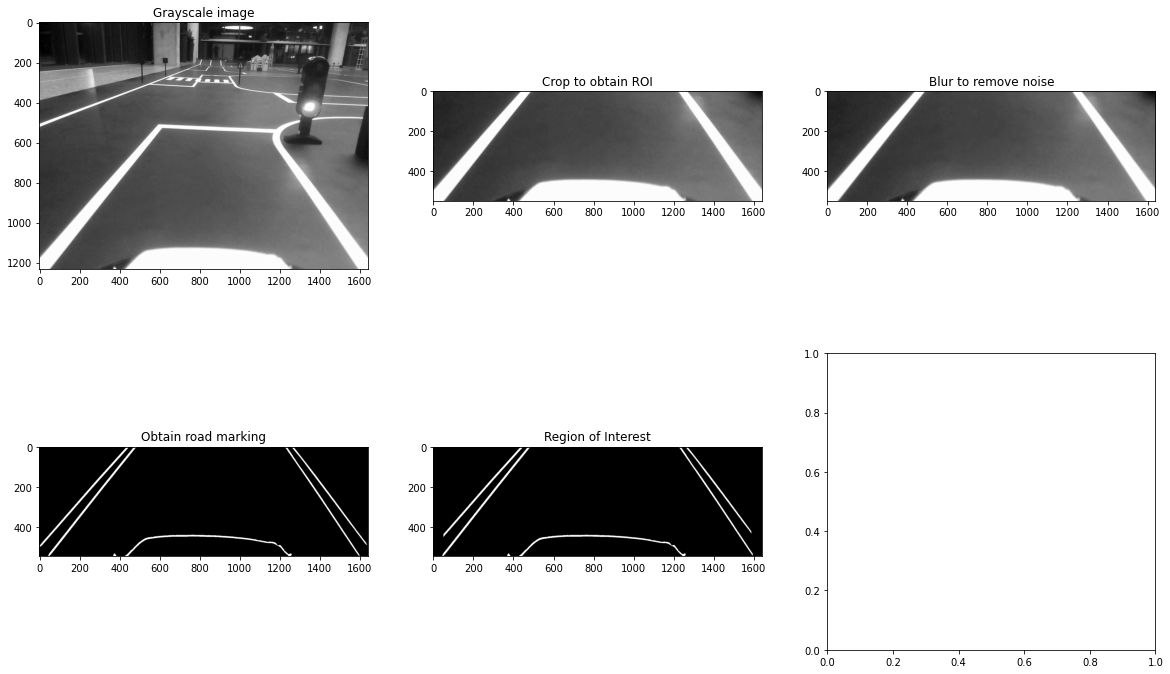

In [ ]:
def computeSteeringAngle(val):

    # Calibrate result
    newVal = val / 2.9

    newVal = -newVal

    newVal += 0
    print("steer angle is:")
    print(newVal)

    return newVal


def laneKeeping(img, idx=0, save=True, savepath="outframes/"):
    """Applies required image processing.

    Parameters
    ----------
    img : Pipe
    show: (bool) inline plot
        The image on which to apply the algorithm.
    """
    assert savepath[-1] == "/", f"{savepath} must end in '/'"

    # Image dimensions
    height = img.shape[0]
    width = img.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))

    img_org = img.copy()
    # Transform to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    axs[0, 0].imshow(img, cmap="gray")
    axs[0, 0].set_title("Grayscale image")
    # Crop to obtain region of interest
    img = img[(int(height / 1.8)) : height, 0:width]
    img_org = img_org[(int(height / 1.8)) : height, 0:width]

    axs[0, 1].imshow(img, cmap="gray")
    axs[0, 1].set_title("Crop to obtain ROI")

    # Blur to remove the noise
    img = cv2.GaussianBlur(img, (7, 7), 0)
    axs[0, 2].imshow(img, cmap="gray")
    axs[0, 2].set_title("Blur to remove noise")

    # Apply adaptive threshold to obtain the road markings
    img = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 27, -16
    )
    axs[1, 0].imshow(img, cmap="gray")
    axs[1, 0].set_title("Obtain road marking")

    # Keep only a trapezoid containing the lines of the current lane
    region_of_interest_vertices = [
        (0, height - 1),
        (0.05 * width, 0),
        (0.95 * width, 0),
        (width - 1, height - 1),
    ]

    def region_of_interest(img, vertices):
        mask = np.zeros_like(img)
        match_mask_color = (255,)
        cv2.fillPoly(mask, vertices, match_mask_color)
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def draw_lines(lines, image, color=(255, 0, 0)):
        # draw Hough lines
        dmy = image.copy()
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(dmy, (x1, y1), (x2, y2), color, 3)
        return dmy

    img = region_of_interest(
        img,
        np.array([region_of_interest_vertices], np.int32),
    )
    axs[1, 1].imshow(img, cmap="gray")
    axs[1, 1].set_title("Region of Interest")

    # Compute the hough lines from the image
    total = 0.0
    lines = cv2.HoughLinesP(
        img,
        rho=6,
        theta=np.pi / 180,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=200,
    )

    # Compute the sum of the slopes of the hough lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            if y2 != y1:
                total = total + (x2 - x1) / (y2 - y1)
            else:
                continue
    angle = total

    # add heading lines
    heading_line = display_heading_line(img_org, angle)

    img = draw_lines(lines, img_org)
    img = draw_lines(heading_line, img, color=(0, 0, 255))
    axs[1, 2].imshow(img)
    axs[1, 2].set_title("Drawing Lines")

    if save:
        plt.savefig(savepath + f"{idx}")
        plt.close()
    else:
        plt.show()

    return angle


# for idx in trange(500):
# angle, img_org = laneKeeping(col_images[idx], idx)
# print(f"Image: {idx}, Steering Angle: {angle}")

laneKeeping(col_images[100], save=False)


In [ ]:
def save_videos(control_image):
    height, width, _ = control_image[0].shape
    size = (width, height)
    out2 = cv2.VideoWriter(
        "slopesandheading.avi", cv2.VideoWriter_fourcc(*"DIVX"), 20, size
    )
    for i in range(len(control_image)):
        # print(control_image[i].shape)
        out2.write(control_image[i])

    out2.release()


In [ ]:
# load frames
col_frames = os.listdir("./lanekeeping/")
col_frames.sort(key=lambda f: int(re.sub("\D", "", f)))

col_images = []
for i in tqdm_notebook(col_frames):
    img = cv2.imread("./lanekeeping/" + i)
    col_images.append(img)
save_videos(col_images)


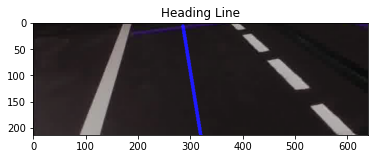

In [20]:
import math

plt.title("Heading Line")
plt.imshow(display_heading_line(img_org, angle))


In [108]:
# col_frames = os.listdir('../frames/')


In [9]:
# col_frames


In [13]:
# col_images
# create a zero array
idx = 40

stencil = np.zeros_like(col_images[idx][:, :, 0])

# specify coordinates of the polygon
polygon = np.array([[50, 270], [10, 160], [360, 160], [480, 270]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

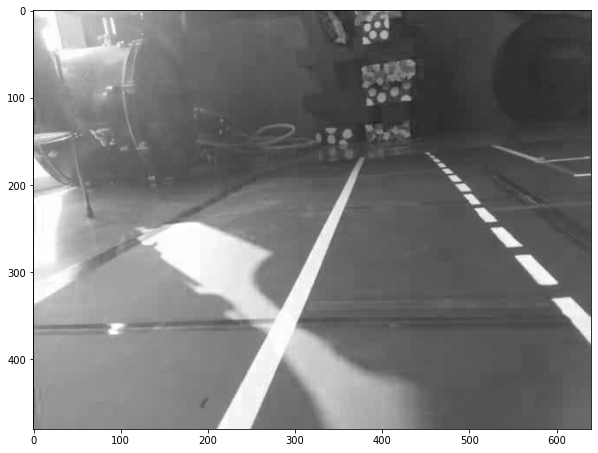

In [15]:
# specify frame index
idx = 40

# plot frame
plt.figure(figsize=(10, 10))
plt.imshow(col_images[idx][:, :, 0], cmap="gray")
plt.show()


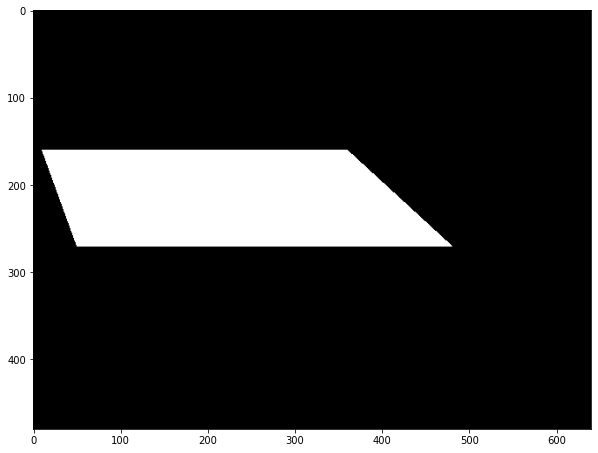

In [16]:
# plot polygon
plt.figure(figsize=(10, 10))
plt.imshow(stencil, cmap="gray")
plt.show()


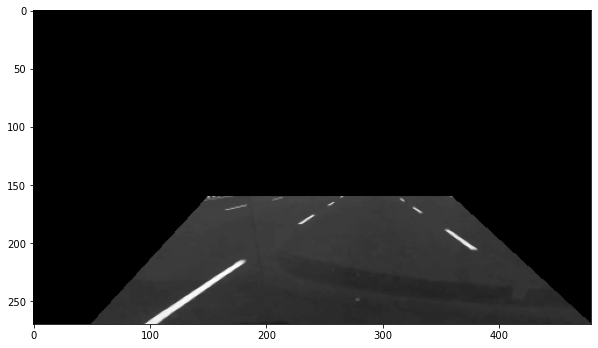

In [ ]:
img = cv2.bitwise_and(col_images[idx][:, :, 0], col_images[idx][:, :, 0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap="gray")
plt.show()


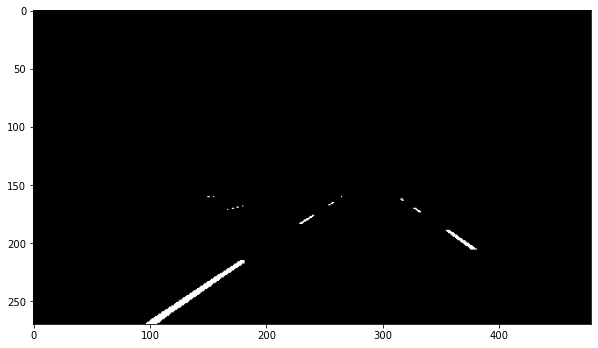

In [ ]:
# apply image thresholding
ret, thresh = cv2.threshold(img, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap="gray")
plt.show()


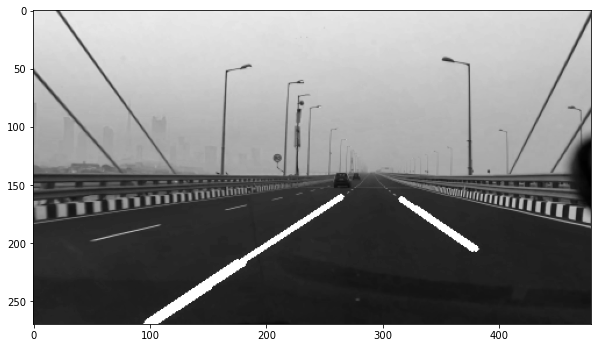

In [ ]:
lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, 30, maxLineGap=200)

# create a copy of the original frame
dmy = col_images[idx][:, :, 0].copy()

# draw Hough lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

# plot frame
plt.figure(figsize=(10, 10))
plt.imshow(dmy, cmap="gray")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


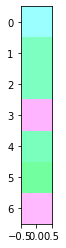

In [ ]:
plt.imshow(lines)


In [ ]:
cnt = 0

for img in tqdm_notebook(col_images):

    # apply frame mask
    masked = cv2.bitwise_and(img[:, :, 0], img[:, :, 0], mask=stencil)

    # apply image thresholding
    ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)

    # apply Hough Line Transformation
    lines = cv2.HoughLinesP(thresh, 1, np.pi / 180, 30, maxLineGap=200)
    dmy = img.copy()

    # Plot detected lines
    try:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

        cv2.imwrite("detected/" + str(cnt) + ".png", dmy)

    except TypeError:
        cv2.imwrite("detected/" + str(cnt) + ".png", img)

    cnt += 1


/tmp/ipykernel_94720/4266864685.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm_notebook(col_images):


  0%|          | 0/1108 [00:00<?, ?it/s]

In [ ]:
def average_slope_intercept(frame, line_segments):
    """
    This function combines line segments into one or two lane lines
    If all line slopes are < 0: then we only have detected left lane
    If all line slopes are > 0: then we only have detected right lane
    """
    lane_lines = []
    if line_segments is None:
        logging.info("No line_segment segments detected")
        return lane_lines

    height, width, _ = frame.shape
    left_fit = []
    right_fit = []

    boundary = 1 / 3
    left_region_boundary = width * (
        1 - boundary
    )  # left lane line segment should be on left 2/3 of the screen
    right_region_boundary = (
        width * boundary
    )  # right lane line segment should be on left 2/3 of the screen

    for line_segment in line_segments:
        for x1, y1, x2, y2 in line_segment:
            if x1 == x2:
                logging.info(
                    "skipping vertical line segment (slope=inf): %s" % line_segment
                )
                continue
            fit = np.polyfit((x1, x2), (y1, y2), 1)
            slope = fit[0]
            intercept = fit[1]
            if slope < 0:
                if x1 < left_region_boundary and x2 < left_region_boundary:
                    left_fit.append((slope, intercept))
            else:
                if x1 > right_region_boundary and x2 > right_region_boundary:
                    right_fit.append((slope, intercept))

    left_fit_average = np.average(left_fit, axis=0)
    if len(left_fit) > 0:
        lane_lines.append(make_points(frame, left_fit_average))

    right_fit_average = np.average(right_fit, axis=0)
    if len(right_fit) > 0:
        lane_lines.append(make_points(frame, right_fit_average))

    logging.debug(
        "lane lines: %s" % lane_lines
    )  # [[[316, 720, 484, 432]], [[1009, 720, 718, 432]]]

    return lane_lines


In [ ]:
import logging

lane_lines = average_slope_intercept(col_images[idx][:, 100:, :].copy(), lines)


In [ ]:
def make_points(frame, line):
    height, width, _ = frame.shape
    slope, intercept = line
    y1 = height  # bottom of the frame
    y2 = int(y1 * 1 / 2)  # make points from middle of the frame down

    # bound the coordinates within the frame
    x1 = max(-width, min(2 * width, int((y1 - intercept) / slope)))
    x2 = max(-width, min(2 * width, int((y2 - intercept) / slope)))
    return [[x1, y1, x2, y2]]


In [ ]:
def display_lines(frame, lines, line_color=(0, 255, 0), line_width=2):
    line_image = np.zeros_like(frame)
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), line_color, line_width)
    line_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    return line_image


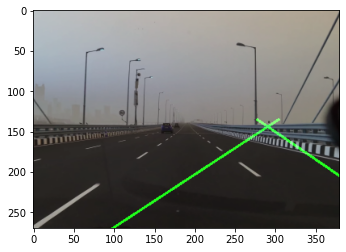

In [ ]:
imgnew = display_lines(col_images[idx][:, 100:, :].copy(), lane_lines)
plt.imshow(imgnew)


In [ ]:
def compute_steering_angle(frame, lane_lines):
    """Find the steering angle based on lane line coordinate
    We assume that camera is calibrated to point to dead center
    """
    if len(lane_lines) == 0:
        logging.info("No lane lines detected, do nothing")
        return -90

    height, width, _ = frame.shape
    if len(lane_lines) == 1:
        logging.debug("Only detected one lane line, just follow it. %s" % lane_lines[0])
        x1, _, x2, _ = lane_lines[0][0]
        x_offset = x2 - x1
    else:
        _, _, left_x2, _ = lane_lines[0][0]
        _, _, right_x2, _ = lane_lines[1][0]
        camera_mid_offset_percent = 0.02  # 0.0 means car pointing to center, -0.03: car is centered to left, +0.03 means car pointing to right
        mid = int(width / 2 * (1 + camera_mid_offset_percent))
        x_offset = (left_x2 + right_x2) / 2 - mid

    # find the steering angle, which is angle between navigation direction to end of center line
    y_offset = int(height / 2)

    angle_to_mid_radian = math.atan(
        x_offset / y_offset
    )  # angle (in radian) to center vertical line
    angle_to_mid_deg = int(
        angle_to_mid_radian * 180.0 / math.pi
    )  # angle (in degrees) to center vertical line
    steering_angle = (
        angle_to_mid_deg + 90
    )  # this is the steering angle needed by picar front wheel

    logging.debug("new steering angle: %s" % steering_angle)
    return steering_angle


In [ ]:
import math

compute_steering_angle(col_images[idx][:, :, :].copy(), lane_lines)


109

In [ ]:
def display_heading_line(
    frame,
    steering_angle,
    line_color=(0, 0, 255),
    line_width=5,
):
    heading_image = np.zeros_like(frame)
    height, width, _ = frame.shape

    # figure out the heading line from steering angle
    # heading line (x1,y1) is always center bottom of the screen
    # (x2, y2) requires a bit of trigonometry

    # Note: the steering angle of:
    # 0-89 degree: turn left
    # 90 degree: going straight
    # 91-180 degree: turn right
    steering_angle_radian = steering_angle / 180.0 * math.pi
    x1 = int(width / 2)
    y1 = height
    x2 = int(x1 - height / 2 / math.tan(steering_angle_radian))
    y2 = int(height / 2)

    cv2.line(heading_image, (x1, y1), (x2, y2), line_color, line_width)
    heading_image = cv2.addWeighted(frame, 0.8, heading_image, 1, 1)

    return heading_image


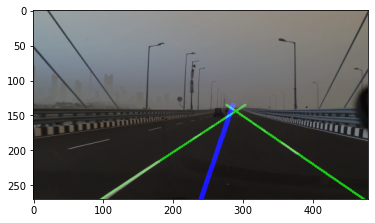

In [ ]:
plt.imshow(display_heading_line(imgnew, 109))
